# SVI & COVID - DALLAS

## Summary

The CDC's social vulnerability index (SVI) is a scale that predicts the vulnerability of a population in the event of an emergency or natural disaster. COVID is the first global pandemic since the development of this measure. We will evaluate the association between SVI score and COVID case count in Dallas, Texas. Features from this measure will be incorporated into a predictive model that can be used to guide recovery resource prioritization.



**Goals**      
1. Evaluate association between SVI score and COVID case count in San Antonio, TX     
2. Build a model based SVI score component features that can predict COVID cases by census tract within Dallas, TX
4. Is there a difference between San Antonio and Dallas results?


## Imports


In [1]:
import pandas as pd
import seaborn as sns
import wrangle
import explore
import model_MAE

import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from statsmodels.formula.api import ols
from sklearn.metrics import mean_squared_error, r2_score, explained_variance_score
from sklearn.feature_selection import f_regression, SelectKBest, RFE 
from sklearn.linear_model import LinearRegression, LassoLars, TweedieRegressor
from sklearn.preprocessing import PolynomialFeatures
from math import sqrt
from scipy import stats

# Acquire & Prepare


In [2]:
df, train_exp, X_train_scaled, y_train, X_test_scaled, y_test = wrangle.wrangle_dallas_data()

Acquire: compiling raw data files...
Acquire: Completed!
Prepare: preparing data files...
Prepare: Completed!
(246, 25) (62, 25)


# Explore

Exploration focuses on answering questions regarding the relationship between the CDC's range category SVI score and cases of COVID-19 per 100k.

- Visualize cases per 100K by binned SVI value
    - Appear to be distinct
    - Will conduct parametric ANOCA (Kruskal) test to confirm
- Verify raw SVI score relationship to cases per 100K
    - will conduct Pearson's R correlation test
- Explore distribution of casses per 100K with SVI score
- Explore distribution of flags by SVI score


## Hypothesis Testing

### Question One: Is there a correlation between the CDC's Range Category SVI Score and COVID-19 Infection Cases per 100k Individuals?

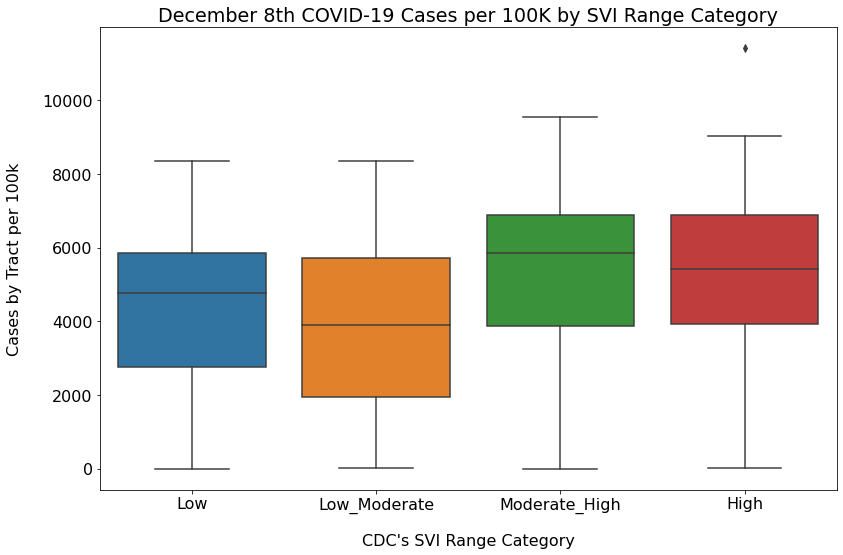

In [3]:
explore.sns_boxplot(train_exp)

**Takeaway:**
`There appears to be a correlation between COVID-19 Count and SVI Category. Next step is Hypothesis testing between categories to validate statistical significance`

In [4]:
# Mean COVID-19 Count By CDC's SVI Category
All = round(train_exp.tract_cases_per_100k.mean(),5)
low = round((train_exp[train_exp.bin_svi == 'low']).tract_cases_per_100k.mean(),5)
low_mod = round((train_exp[train_exp.bin_svi == 'low_mod']).tract_cases_per_100k.mean(),6)
mod_high = round((train_exp[train_exp.bin_svi == 'mod_high']).tract_cases_per_100k.mean(),6)
high = round((train_exp[train_exp.bin_svi== 'high']).tract_cases_per_100k.mean(),6)

print(f'The average number of cases per 100k for all CDC SVI Range Categories is {All}') 
print(f'The average number of cases per 100k for CDC SVI Range Category (low) is {low}')
print(f'The average number of cases per 100k for CDC SVI Range Category (low_mod) is {low_mod}')
print(f'The average number of cases per 100k for CDC SVI Range Category (mod_high) is {mod_high}')
print(f'The average number of cases per 100k for CDC SVI Range Category (high) is {high}')

The average number of cases per 100k for all CDC SVI Range Categories is 4849.86647
The average number of cases per 100k for CDC SVI Range Category (low) is nan
The average number of cases per 100k for CDC SVI Range Category (low_mod) is nan
The average number of cases per 100k for CDC SVI Range Category (mod_high) is nan
The average number of cases per 100k for CDC SVI Range Category (high) is nan


In [5]:
low = (train_exp[train_exp.bin_svi == 'low']).tract_cases_per_100k
low_mod = (train_exp[train_exp.bin_svi == 'low_mod']).tract_cases_per_100k
mod_high = (train_exp[train_exp.bin_svi == 'mod_high']).tract_cases_per_100k
high = (train_exp[train_exp.bin_svi== 'high']).tract_cases_per_100k
alpha = 0.01
null = "Average number of COVID-19 cases per 100k is the same across all CDC SVI Range Categories "
alternate = "Average number of COVID-19 cases per 100k is significantly different across all CDC SVI Range Categories "
explore.kruskal_test(low, low_mod, mod_high, high, null, alternate, alpha)

f= nan
p= nan


We fail to reject the null
Evidence does not support the claim that smoking status and time of day are dependent/related


**Takeaway:**
`We can state with 99% certainty that there is a statistically significant difference between all of the CDC SVI Range Categories`

### Question Two: Is there a correlation between raw_svi and cases per 100k?

In [6]:
raw_svi = train_exp.raw_svi
cases_per_100k = train_exp.tract_cases_per_100k
alpha = 0.01
null = "There is no statistically significant difference betweeen raw_svi and cases per 100K "
alternate = "There is a statistically significant difference betweeen raw_svi and cases per 100K"
explore.pearson(raw_svi, cases_per_100k, null, alternate, alpha)

r= 0.19395225483933634
p= 0.0022461351772073666


We reject the null that: 
 There is no statistically significant difference betweeen raw_svi and cases per 100K 


We move forward with the alternative hypothesis that: 
 There is a statistically significant difference betweeen raw_svi and cases per 100K


**Takeaway:**
`We can state with 99% certainty that there is a statistically significant difference between ?????`

## Distribution Exploration

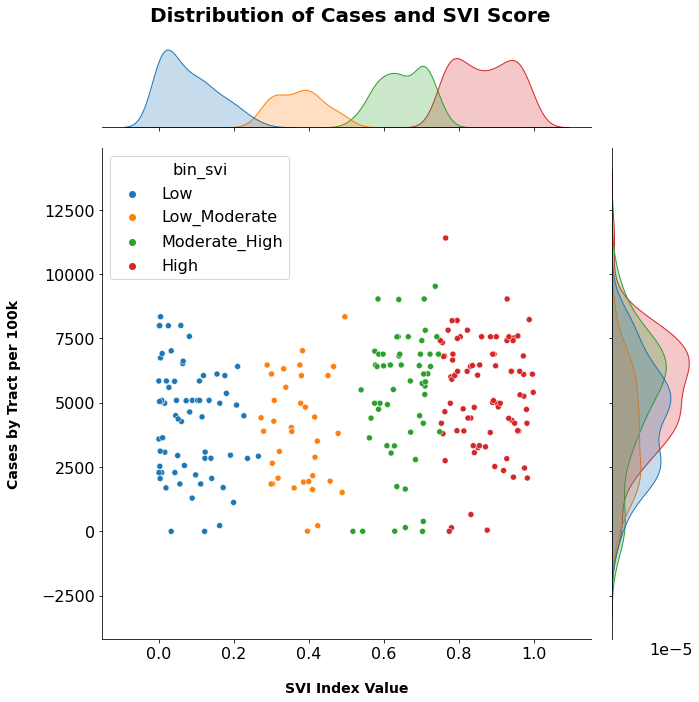

In [7]:
explore.joint_plot_index('raw_svi','tract_cases_per_100k', train_exp, 'bin_svi')

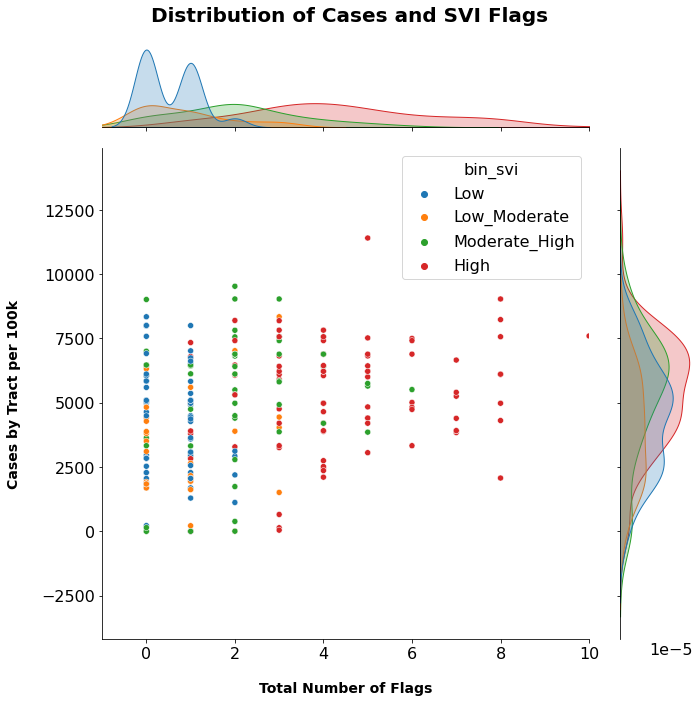

In [8]:
explore.joint_plot_flag("all_flags_total","tract_cases_per_100k",train_exp,'bin_svi')

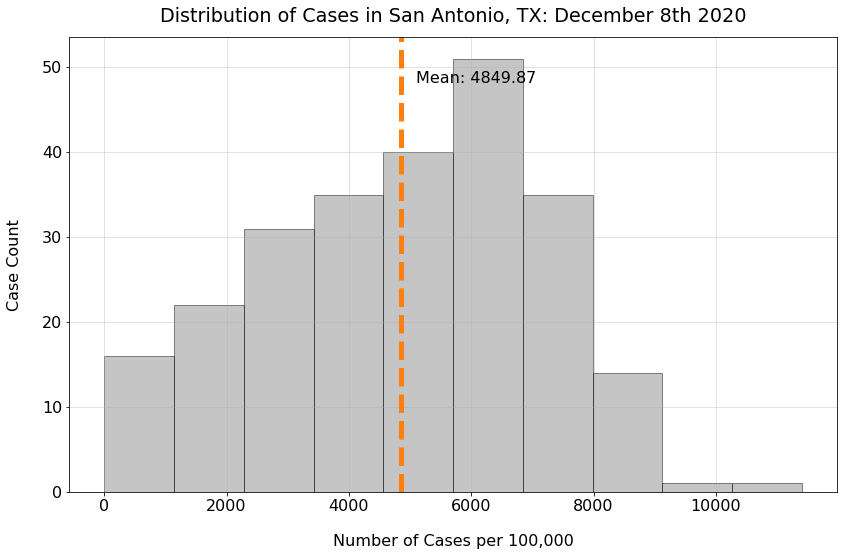

In [9]:
explore.hist_case(train_exp.tract_cases_per_100k)

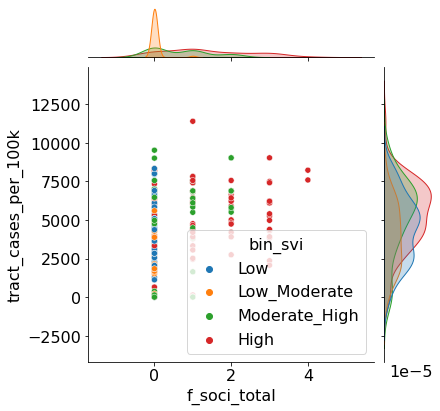

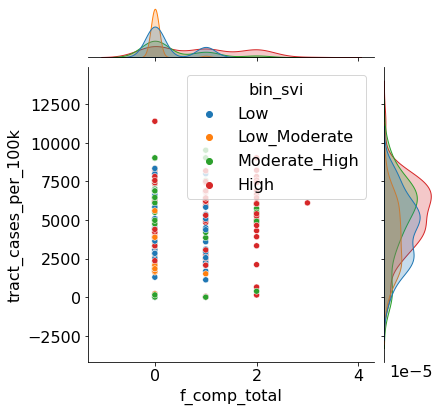

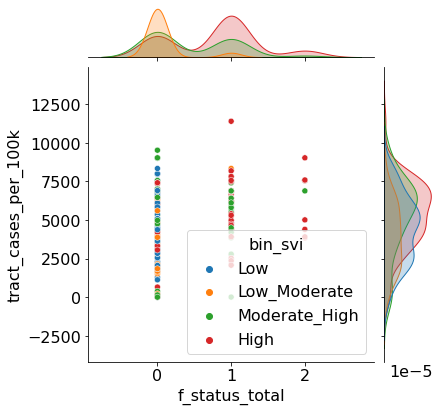

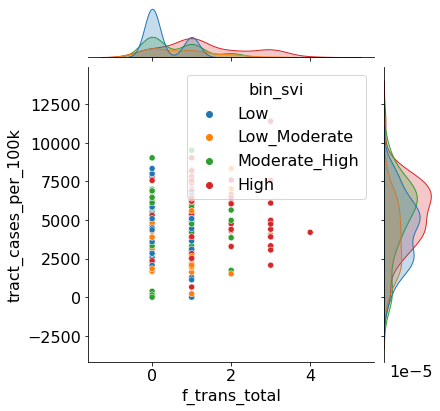

In [10]:
subtotal_flag_list = ['f_soci_total', 'f_comp_total', 'f_status_total', 'f_trans_total']
for col in subtotal_flag_list:
    sns.jointplot(x = col, y = "tract_cases_per_100k", data = train_exp, hue = "bin_svi")

# Model the Data

- Baseline for modeling determined by plotting the histogram distribution of COVID-19 cases per 100k.
- The skew observed in the distribution led us to use the median for this value instead of the mean??
- Used cross validation due to limited size of dataset. Size of dataset limited by San Antonio number of census tracts.
- Three of the 4 models used all of the features in the dataset, one model used only the top4 features identified by RFE.
- Linear Regression, LassoLars, and 2 degree polynomial features used all features and a 2nd version of 2 degree polynomial was run with just the top4 features.
- Of these the LassoLars had the least MAE (mean absolute error) and was run on out of sample data (test).
- This model had nearly identical MAE when run on out of sample data, only a 0.7 difference in MAE.
- Overall this is a 25% improvement from mean baseline MAE.

## Create Baseline

In [11]:
# What is the mean vs median of the target variable?
y_train.tract_cases_per_100k.mean(), y_train.tract_cases_per_100k.median()

(4849.866470319118, 5023.511679404)

In [12]:
# calculate the mean absolute error (MAE) of the baseline using mean
mean_baseMAE, basepred1 = model_MAE.get_baseline_mean(y_train)

Baseline MAE: 1861.849146190839


## Feature Ranking

- Use recursive feature elimination to evaluate features for modeling

In [14]:
rankdf = model_MAE.feature_ranking(X_train_scaled, y_train)
rankdf

,features
rank,
1,f_status_total_scaled
2,raw_svi
3,rank_svi_scaled
4,f_nohsdp_soci
5,f_age65_comp
6,f_noveh_trans
7,f_munit_trans
8,f_disabl_comp
9,all_flags_total_scaled


## Feature Selection

In [15]:
# only raw svi score
X_raw_svi = X_train_scaled[['raw_svi']]
# binned svi score by CDC range category = 1st ranked
X_rank_svi_only = X_train_scaled[['rank_svi_scaled']]
# top 4 ranked features
X_top4 = X_train_scaled[['f_status_total_scaled', 'raw_svi', 'rank_svi_scaled', 'f_nohsdp_soci']]
# only the summary of the flags = 19th ranked
X_all_flags_only = X_train_scaled[['all_flags_total_scaled']]
# only summary flags, should be the same as all flags total? = 5th, 12th, 15th, 21st
X_summary_flags = X_train_scaled[['f_comp_total_scaled', 'f_soci_total_scaled', 'f_status_total_scaled', 'f_trans_total_scaled']]
# all individual flags
X_not_summary_flags = X_train_scaled[['f_nohsdp_soci', 'f_minrty_status', 'f_groupq_trans', 'f_unemp_soci', 
                                     'f_disabl_comp', 'f_noveh_trans', 'f_mobile_trans', 'f_age65_comp', 
                                     'f_age17_comp', 'f_pov_soci', 'f_limeng_status', 'f_crowd_trans', 
                                      'f_pci_soci', 'f_sngpnt_comp', 'f_munit_trans']]

## Build and Train Model

- Linear Regression, Polynomial Features, and Tweedie Regressor will be run with various combinations of features
- LassoLars will be run only with all of the features because feature evaluation is a component of the model

In [16]:
# Linear Regression
# create variables for loop
df2test = [X_rank_svi_only, X_top4, X_all_flags_only, X_summary_flags, X_not_summary_flags, X_train_scaled, X_raw_svi]
target = y_train

# Linear Regression Models
cvlm_MAE_list = []
for df in df2test:
    cvlm_MAE = model_MAE.cvLinearReg(df, target) 
    cvlm_MAE_list.append(cvlm_MAE)

MAE: 1852.613 (1250.626)
MAE: 1769.445 (1228.755)
MAE: 1859.461 (1222.728)
MAE: 1796.553 (1247.350)
MAE: 1807.164 (1297.909)
MAE: 1821.096 (1303.745)
MAE: 1854.677 (1259.087)


In [17]:
# Lasso Lars
# create variables for loop
df2test = [X_rank_svi_only, X_top4, X_all_flags_only, X_summary_flags, X_not_summary_flags, X_train_scaled, X_raw_svi]
target = y_train

# LassoLars Models
cvll_MAE_list = []
for df in df2test:
    cvll_MAE = model_MAE.cvLassoLars(df, target, 1) 
    cvll_MAE_list.append(cvll_MAE)

MAE: 1852.224 (1251.292)
MAE: 1775.747 (1228.092)
MAE: 1858.492 (1224.286)
MAE: 1798.631 (1244.787)
MAE: 1787.486 (1279.463)
MAE: 1798.290 (1286.970)
MAE: 1854.099 (1260.013)


## Interpret the Model

In [18]:
# create dataframe for results of all train models
df_list = ['rank_svi_only', 'top4', 'total_all_flags_only', 'summary_flags', 'not_summary_flags', 'all_features', 'raw_svi_only']

results = pd.DataFrame(df_list, columns=['Features'])
results['LinearRegression_MAE'] = cvlm_MAE_list
results['LassoLars_MAE'] = cvll_MAE_list
results['Base_mean_MAE'] = mean_baseMAE
results.sort_values('LassoLars_MAE')

,Features,LinearRegression_MAE,LassoLars_MAE,Base_mean_MAE
1,top4,1769.445322,1775.746893,1861.849146
4,not_summary_flags,1807.164377,1787.486182,1861.849146
5,all_features,1821.096481,1798.289577,1861.849146
3,summary_flags,1796.553033,1798.631395,1861.849146
0,rank_svi_only,1852.612774,1852.223537,1861.849146
6,raw_svi_only,1854.677061,1854.098995,1861.849146
2,total_all_flags_only,1859.460881,1858.492131,1861.849146


## Test Stage

In [19]:
# create test dataframe with only Top4 features as identified by RFE as that is the best performing model
X_test_top4 = X_test_scaled[['f_status_total_scaled', 'raw_svi', 'rank_svi_scaled', 'f_nohsdp_soci']]

In [20]:
# fit Linear Regression with Top4 features on train dataset, then use that model to predict test values
LRtestMAE, modelLR = model_MAE.linear_test(X_top4, y_train, X_test_top4, y_test)
LRtestMAE

1947.0358749133668

In [21]:
LLtestMAE, modelLL = model_MAE.lasso_lars_test(X_top4, y_train, X_test_top4, y_test)
LLtestMAE

1941.6407922071405

#### Report Metrics in Context
How did the model perform on the key metrics you chose to demonstrate its usefulness? What counts as good or bad performance? How well do humans perform on this task? How well would you expect to do with random dice rolls? What are the costs associated with missed predictions?     

- Both models performed worse than baseline on test

In [24]:
# linear regression Results table:
# linear regression Results table:
flat_list = []
for sublist in modelLR.coef_:
    for item in sublist:
        flat_list.append(item)

lr_result = pd.DataFrame()
x_train_columns = X_test_top4.columns.tolist()
lr_result['features'] = x_train_columns
lr_result['coefs'] = flat_list
lr_result['abs_coefs'] = abs(lr_result.coefs)
lr_result.sort_values(by='abs_coefs', ascending = False).reset_index()

,index,features,coefs,abs_coefs
0,1,raw_svi,-2859.607943,2859.607943
1,2,rank_svi_scaled,-2363.520789,2363.520789
2,0,f_status_total_scaled,1459.518292,1459.518292
3,3,f_nohsdp_soci,1197.521756,1197.521756


#### Strengths and Weaknesses

Once you've gone through your iteration cycles and are finished with this version of the model, or this particular project, provide an assessment of what types of observations are handled well by your model, and what circumstances seem to give it trouble. This will point you and others towards more questions for future projects.

#### Inspect Errors

Look at some of the observations with missed predictions. (Do this in your validation set, never look at individual records in your test set!) Are there common patterns among the observations with bad results? Do you have data that you can include in your model that will capture these patterns or is this a task that will need another research project to solve?

This is your last step in the iteration cycle; if you can't find anything else you can work on here with your present data, project scope, and deadlines, then it's time to wrap things up.

# Next Steps: What Can We Do Now?

Reporting a model's results is good, and is the main objective of any data science project. But a project is one thing, a career is another. A question is one thing, but science is another. If you've carried out your research with a mindset of curiosity and creativity, then by now you should have plenty more, and much better informed, questions about this topic than what you started with.

So in addition to reporting on the question you investigated and the answers you found, think of the needs of your team, your users, and your peers in the industry, and make some recommendations that answer these two questions:

What are some unanswered questions in my project where more information (additional data sources, deeper understanding, other models or tools) might help improve these results?
What are other needs or problems where my model or my approach may be useful?

 ## additional models to try
- random forest regressor
- decission tree regressor
- support vector regressor
- multiple linear regressor

https://github.com/CSolitaire/machine-learning-course/tree/master/Machine%20Learning%20Toolkit/Regression%20Templates

## Is San Antonio different from other cities?

- Dallas?
- Pittsburgh?
- Phoenix?
- ??
- ??

## Feature Engineering

- SVI trend for the county
    - is rising? is declining? 
    - delta of SVI change year over year?
    - std dev of SVI?
